In [29]:
library(tidyverse)
library(ggplot2)

In [30]:
vuln <- read_csv("../permanently_saved_results/federico-vuln-exp/aug_27_gather.csv",
        col_types ="ccfddfc")

In [31]:
head(vuln)

name,commit,solver,CVE,NDeps,Status,Time
<chr>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<chr>
generator-react,09b724e,vanilla,12.80,357,success,NA
generator-react,09b724e,audit fix,12.80,357,success,NA
generator-react,09b724e,audit fix force,0.00,157,success,NA
generator-react,09b724e,maxnpm_cve_oldness,NA,NA,missing,NA
generator-react,09b724e,maxnpm_cve_oldness_pip_else_npm,NA,NA,missing,NA
JsSIP,9cdeaa0,vanilla,17.45,8,success,NA


In [32]:
# What does it mean when status is "missing" - and should we only include those that have no missing?
# There are 225/1000 project-versions that have non-NA results: what is missing there?
vulnByProject <- vuln %>%
    replace_na(list(CVE=-1)) %>%
    pivot_wider(names_from=solver, values_from=CVE, names_prefix="CVE.") %>%
    group_by(name,commit) %>%
    summarise(across(starts_with("CVE."), ~sum(.x,na.rm=TRUE))) %>% ungroup() %>%
    filter(`CVE.audit fix` >= 0 & `CVE.audit fix force`>=0 & `CVE.maxnpm_cve_oldness`>=0) 
head(vulnByProject)
nrow(vulnByProject)

`summarise()` has grouped output by 'name'. You can override using the `.groups` argument.



name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3Dmol.js,1cc27de,0.0,0.0,0,0,0.0
a11yjson,67282f9,17.0,17.0,0,0,-1.0
abac,429f598,0.0,0.0,0,0,0.0
accord,262e693,0.0,0.0,0,0,0.0
acorn-issue-handler,722c1c6,9.1,9.1,0,0,9.1
acorn-node,099c3c5,0.0,0.0,0,0,0.0


[1] 472

## How many times did MaxNPM come to a different CVE score than NPM audit fix?

In [33]:
breaks <- c(0, 1, 10, 25, 50, 100, 1000)
bucketedVuln <- vulnByProject %>%
    mutate(across(starts_with('CVE'), ~cut_format(.x, breaks=breaks))) %>% # Bucket all CVE columns
    mutate_if(is.factor, as.character) %>%  # Default is these are factors, make them char so easier to handle
    mutate(across(starts_with('CVE'), ~replace(.,is.na(.), '0'))) %>% # If it was NA, it was because it was outside of the range, aka == 0
    group_by(`CVE.audit fix`,`CVE.maxnpm_cve_oldness`) %>% summarise(count=n()) %>%
    # Sum the count for CVE audit fix and add a row for that called 'total'
    bind_rows(group_by(.,`CVE.audit fix`) %>%
        summarise(count=sum(count)) %>%
        mutate(`CVE.maxnpm_cve_oldness`='Total')) %>%
    bind_rows(group_by(.,`CVE.maxnpm_cve_oldness`) %>%
        summarise(count=sum(count)) %>%
        mutate(`CVE.audit fix`='Total'))

# Create a matrix where the columns are for audit fix, rows are for MaxNPM
bucketedVuln %>%
    pivot_wider(names_from=`CVE.audit fix`, values_from=count) %>%
    relocate(`0`, .before=`(   1,   10]`) %>%
    mutate_if(is.numeric,~replace(.,is.na(.), 0)) %>%
    arrange(CVE.maxnpm_cve_oldness) #%>%
        # kable("html", booktabs=TRUE, linesep="", digits=0, escape=FALSE, format.args = list(big.mark = ",",
        #   scientific = FALSE)) %>% as.character() %>% display_html()

`summarise()` has grouped output by 'CVE.audit fix'. You can override using the `.groups` argument.



CVE.maxnpm_cve_oldness,0,"( 1, 10]","( 10, 25]","( 25, 50]","( 50, 100]","( 100, 1000]",Total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"( 1, 10]",0,11,2,3,6,4,26
"( 10, 25]",0,0,9,7,3,0,19
"( 25, 50]",0,0,0,8,4,0,12
"( 50, 100]",0,0,0,1,3,1,5
"( 100, 1000]",0,0,0,0,0,5,5
0,208,86,49,37,17,8,405
Total,208,97,60,56,33,18,472


## Which were the cases that MaxNPM better?

In [34]:
vulnByProject %>% filter(`CVE.maxnpm_cve_oldness` < `CVE.audit fix`)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a11yjson,67282f9,17.00,17.00,0.00,0.00,-1.00
acorn-issue-handler,722c1c6,9.10,9.10,0.00,0.00,9.10
adbkit,0adc637,31.75,31.75,0.00,0.00,31.75
amd-to-as6,11dce6b,7.50,7.50,0.00,0.00,7.50
analytics.js-integration,5ef00d5,5.45,5.45,0.00,0.00,5.45
ansi-slice,6867f8a,44.40,44.40,0.00,0.00,44.40
anx-api,6d424a8,36.85,36.85,0.00,0.00,36.85
api-javascript,0ad3124,50.05,50.05,30.30,30.30,-1.00
apidoc,0b5d254,133.15,133.15,0.00,0.00,133.15


## When MaxNPM outperformed NPM Audit, how much better was it?

Negative numbers are *better* because they are a decrease in badness.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



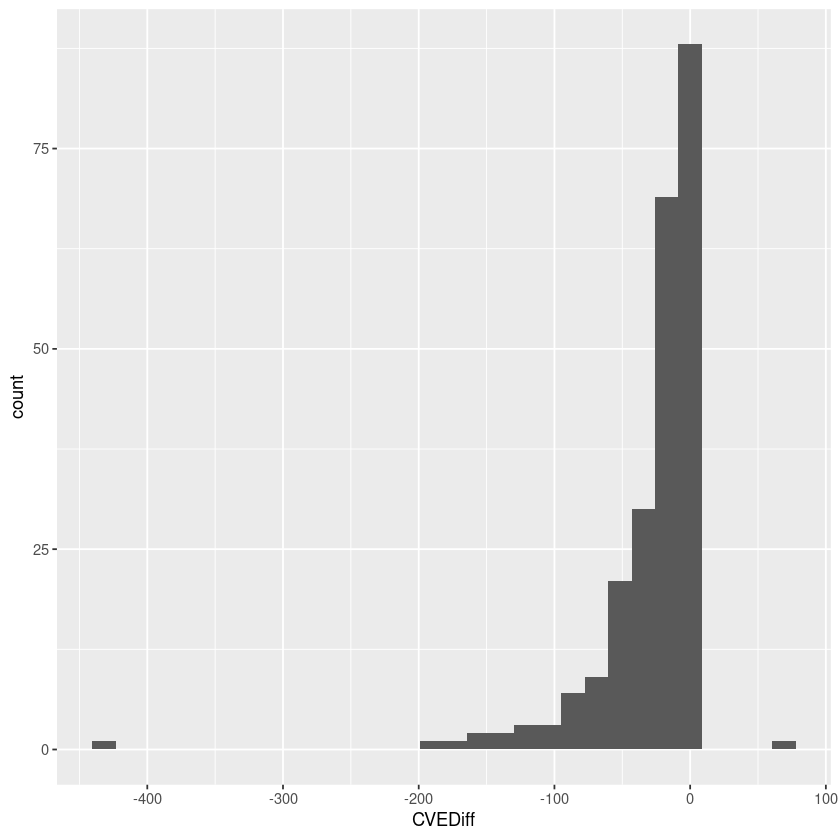

In [35]:
CVEDiff <- vulnByProject %>%
    mutate(CVEDiff=`CVE.maxnpm_cve_oldness` - `CVE.audit fix`) %>%
    filter(CVEDiff != 0)
    
ggplot(CVEDiff, aes(x=CVEDiff)) + geom_histogram()

In [36]:
# These are the ones where MaxNPM did worse somehow?
CVEDiff %>% filter(CVEDiff >0)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
maf,7ce13d7,75.75,75.75,0.0,75.75,75.75,1.421085e-14
spreadable,0803fae,28.50,28.50,13.1,94.80,110.20,6.630000e+01


In [37]:
# These are the ones where MaxNPM did the best
CVEDiff %>% arrange(CVEDiff)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
node-db-migrate,0354de8,434.85,434.85,0.00,0.00,-1.00,-434.85
dgeni-packages,3c75243,201.90,201.90,7.50,7.50,185.70,-194.40
grant,762badb,259.60,259.60,94.30,81.35,204.25,-178.25
lockit-sql-adapter,b3171b3,162.60,162.60,0.00,0.00,-1.00,-162.60
storyboard,3c0fa91,148.35,148.35,0.00,0.00,132.35,-148.35
gulp-typedoc,039d47b,145.40,145.40,0.00,0.00,140.10,-145.40
apidoc,0b5d254,133.15,133.15,0.00,0.00,133.15,-133.15
release-it,0ae3e3c,132.85,132.85,48.10,3.70,132.85,-129.15
ui,1de6835,127.85,127.85,7.50,7.50,-1.00,-120.35
